# Tutorial
## https://www.youtube.com/watch?v=fyZ9Rxpoz2I&ab_channel=DigitalSreeni


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image



In [2]:
df = pd.read_csv('input/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

In [3]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
LabelEncoder()
print(list(label_encoder.classes_))

df['label'] = label_encoder.transform(df["dx"])
print(df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id     dx    dx_type   age     sex  \
602   HAM_0002424  ISIC_0028104    bkl      histo  65.0    male   
285   HAM_0002691  ISIC_0031345    bkl      histo  80.0  female   
8636  HAM_0000674  ISIC_0028983     nv      histo  35.0  female   
9565  HAM_0004205  ISIC_0033797     nv  consensus  40.0  female   
5383  HAM_0004488  ISIC_0030601     nv  follow_up  45.0    male   
6574  HAM_0000731  ISIC_0026813     nv  follow_up  40.0  female   
9798  HAM_0006481  ISIC_0026492  akiec      histo  70.0    male   
2446  HAM_0002639  ISIC_0025249   vasc  consensus  30.0  female   
9154  HAM_0006910  ISIC_0028504     nv      histo  40.0  female   
9129  HAM_0003423  ISIC_0031866     nv      histo  65.0    male   

         localization  label  
602              back      2  
285              hand      2  
8636             back      5  
9565          unknown      5  
5383            trunk      5  
6574  upper extremity    

# features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [4]:
df_L0 = df[df['label']==0]
df_L1 = df[df['label']==1]
df_L2 = df[df['label']==2]
df_L3 = df[df['label']==3]
df_L4 = df[df['label']==4]
df_L5 = df[df['label']==5]
df_L6 = df[df['label']==6]

n = 750
from sklearn.utils import resample
df_L0_balance = resample(df_L0,replace=True, n_samples=n, random_state=42)
df_L1_balance = resample(df_L1,replace=True, n_samples=n, random_state=42)
df_L2_balance = resample(df_L2,replace=True, n_samples=n, random_state=42)
df_L3_balance = resample(df_L3,replace=True, n_samples=n, random_state=42)
df_L4_balance = resample(df_L4,replace=True, n_samples=n, random_state=42)
df_L5_balance = resample(df_L5,replace=True, n_samples=n, random_state=42)
df_L6_balance = resample(df_L6,replace=True, n_samples=n, random_state=42)

combine into one df

In [5]:
df_balance = pd.concat([df_L0_balance,df_L1_balance,df_L2_balance,df_L3_balance,
                        df_L4_balance,df_L5_balance,df_L6_balance])
print(df_balance['label'].value_counts())

0    750
4    750
1    750
5    750
2    750
6    750
3    750
Name: label, dtype: int64


In [6]:
#TODO try to assign weight instead of balancing data

In [7]:
from glob import glob
image_size = 32
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('input/','*','*.jpg'))}
df_balance['path'] = df['image_id'].map(image_path.get)
df_balance['image_64'] = df_balance['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

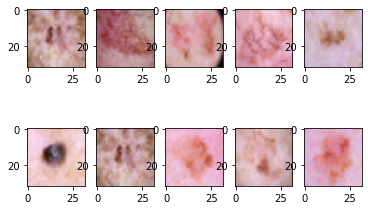

In [8]:
#print some image
index = 1
for image in df_balance['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1

In [9]:
#to array
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

df_balance['image'] = df_balance['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df_balance['image'].to_list())
data = data/255.0 #scale the value from [0...1]
label = df_balance['label']
label_cat = to_categorical(label,num_classes=7)

train_data,test_data,train_label,test_label = train_test_split(data,label_cat,test_size=0.25,random_state=999)


In [10]:
#setup model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(image_size, image_size, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          7

In [11]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 200
epochs = 20

train_history = model.fit(
    train_data,train_label,
    epochs=epochs,
    batch_size = batch_size,
    validation_split=0.2,
    verbose=2)

Epoch 1/20
16/16 - 7s - loss: 1.9529 - acc: 0.1527 - val_loss: 1.9307 - val_acc: 0.2145
Epoch 2/20
16/16 - 7s - loss: 1.9046 - acc: 0.2115 - val_loss: 1.8608 - val_acc: 0.2728
Epoch 3/20
16/16 - 7s - loss: 1.8495 - acc: 0.2420 - val_loss: 1.8072 - val_acc: 0.2843
Epoch 4/20
16/16 - 7s - loss: 1.7832 - acc: 0.2779 - val_loss: 1.7478 - val_acc: 0.3096
Epoch 5/20
16/16 - 7s - loss: 1.6904 - acc: 0.3185 - val_loss: 1.6685 - val_acc: 0.3718
Epoch 6/20
16/16 - 7s - loss: 1.6345 - acc: 0.3595 - val_loss: 1.5622 - val_acc: 0.4175
Epoch 7/20
16/16 - 9s - loss: 1.5339 - acc: 0.4087 - val_loss: 1.4581 - val_acc: 0.4721
Epoch 8/20
16/16 - 10s - loss: 1.4258 - acc: 0.4500 - val_loss: 1.3742 - val_acc: 0.4734
Epoch 9/20
16/16 - 7s - loss: 1.3970 - acc: 0.4570 - val_loss: 1.4046 - val_acc: 0.4607
Epoch 10/20
16/16 - 7s - loss: 1.3621 - acc: 0.4700 - val_loss: 1.4035 - val_acc: 0.4530
Epoch 11/20
16/16 - 7s - loss: 1.3352 - acc: 0.4798 - val_loss: 1.3561 - val_acc: 0.4607
Epoch 12/20
16/16 - 6s - loss

In [12]:
def plot_train_history(t_history, train,validation):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[validation])
    plt.title("train_history")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.show()

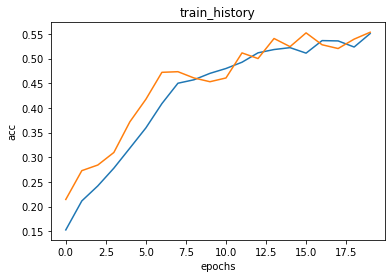

In [13]:
#plot train history
plot_train_history(train_history,'acc','val_acc')

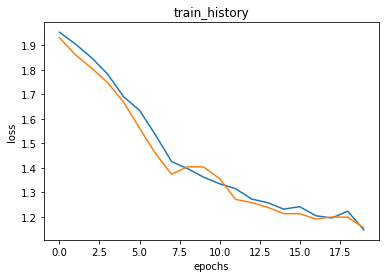

In [14]:
# plot loss
plot_train_history(train_history,'loss','val_loss')

In [15]:
#score
score = model.evaluate(test_data, test_label)
print('Test accuracy:', score[1])

42/42 [==============================] - 1s 15ms/step - loss: 1.1073 - acc: 0.5956
Test accuracy: 0.5955826640129089


In [17]:
#predictions

prediction = model.predict(test_data)
print(prediction)
prediction_class = np.argmax(prediction,axis=1)
prediction_label = np.argmax(test_label,axis=1)


print(pd.crosstab(prediction_label,prediction_class,rownames=['label'],colnames=['predict']))

[[1.1478809e-01 4.6435997e-01 9.9228695e-02 ... 5.9937280e-02
  5.4343361e-02 7.6538749e-02]
 [7.3786815e-08 6.1245293e-05 3.5691232e-09 ... 4.8679476e-07
  3.6728275e-07 9.9993610e-01]
 [8.3438374e-02 2.0743981e-01 3.8101768e-01 ... 1.1042710e-01
  7.0083000e-02 1.6528618e-02]
 ...
 [8.3547615e-02 7.3882103e-02 2.1190572e-01 ... 2.7254421e-01
  3.3995599e-01 1.6553404e-03]
 [2.8448123e-01 1.8933514e-01 2.6864225e-01 ... 4.8662815e-02
  2.3183001e-02 2.5783442e-03]
 [4.5591742e-03 2.2965283e-03 1.2410281e-01 ... 8.3245343e-01
  3.5042182e-02 4.3627500e-04]]
predict    0   1   2   3    4    5    6
label                                  
0        107  15  21  33    9    3    1
1         40  69  24  27    7    1   18
2         23  10  97   8   31    5    4
3         24  30  16  94    6    3    1
4         10   3  36   0  106   15    2
5          5   7  27  10   45  110    5
6          0   1   0   5    0    0  199
